In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
import os, sys
import re
import json
import glob
import datetime
from collections import Counter

import pandas as pd
from pandas import DataFrame
from matplotlib import pyplot as plt
import seaborn as sns

In [4]:
# Add parent directory to path to import modules from src
rpath = os.path.abspath('..')
if rpath not in sys.path:
    sys.path.insert(0, rpath)

from src.loader import SlackDataLoader
import src.utils  as utils
from wordcloud import WordCloud

In [5]:
from nltk.corpus import stopwords
from wordcloud import WordCloud

import numpy as np
from pprint import pprint

#Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

#spacy
import spacy
from nltk.corpus import stopwords

#vis
import pyLDAvis
import pyLDAvis.gensim


In [6]:
import nltk
nltk.download('vader_lexicon')

from nltk.sentiment import SentimentIntensityAnalyzer

sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/misge/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### Data Frames

In [7]:
ROOT_DIR = '../data/anonymized/'
sl = SlackDataLoader(ROOT_DIR)
dframe = sl.create_dataframe()
reaction_dataframe = sl.create_reaction_data_frame()

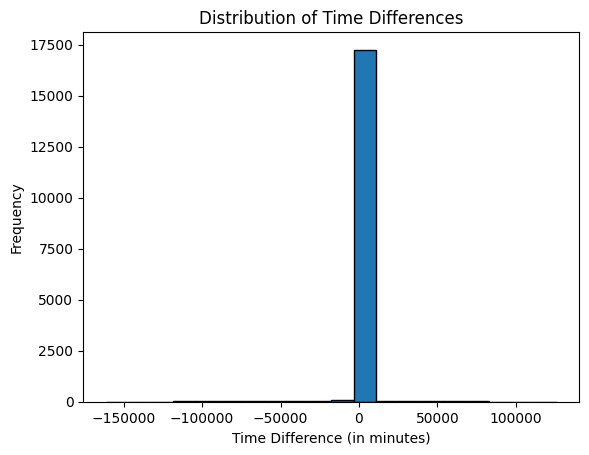

,msg_type,msg_content,sender_name,msg_sent_time,msg_dist_type,time_thread_start,reply_count,reply_users_count,reply_users,tm_thread_end,channel,time_sent,time_difference_minutes
0,message,Finally:laughing:,Luis Ingram,1663917546.037999,text,1663917466.335689,0,0,0,0,all-community-building,2022-09-23 10:19:06.037999,NaN
1,message,Seems like you are shooting yourself in the foot,Travis Butler,1663921600.459999,text,1663917466.335689,0,0,0,0,all-community-building,2022-09-23 11:26:40.459999,67.573700
2,message,"Thank you for the questions guys, i wish we ha...",Vanessa Norman,1663923714.365019,text,1663923714.365019,1,1,U03UVHCV6KB,1663923735.624989,all-community-building,2022-09-23 12:01:54.365019,35.231750
3,message,Best hot seat ever,Travis Butler,1663923735.624989,text,1663923714.365019,0,0,0,0,all-community-building,2022-09-23 12:02:15.624989,0.354333
4,message,Below you will find the list of all the quake ...,Travis Butler,1663926302.884099,text,1663926302.884099,13,5,"U03UG0YHAUT,U03UJKJGRAQ,U03UVHCV6KB,U03UG1Z21J...",1663937439.801309,all-community-building,2022-09-23 12:45:02.884099,42.787652
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17743,message,<https://www.linkedin.com/feed/update/urn:li:a...,Daniel Brown,1668091209.246809,link,0,0,0,0,0,all-week12,2022-11-10 17:40:09.246809,-2458.887358
17744,message,isn't that a connection problem?,Judith Bolton,1668092676.858439,text,1668090991.470289,0,0,0,0,all-week12,2022-11-10 18:04:36.858439,24.460194
17745,message,my connection work properly <@U03UJGP0C68>,Cristian Wilson,1668100415.828559,text,1668090991.470289,0,0,0,0,all-week12,2022-11-10 20:13:35.828559,128.982835
17746,message,How can I get the trainees that opted-in a giv...,Katie Dickerson,1668272023.894179,text,0,0,0,0,0,all-web3-week12,2022-11-12 19:53:43.894179,2860.134427


In [15]:
def difference_between_consecutive_messages(data: DataFrame):
    pd = data


    pd.sort_values(by='msg_sent_time', ascending=True)
    pd['time_sent'] = utils.convert_2_timestamp('msg_sent_time', data)
    pd['time_difference_minutes'] = pd['time_sent'].diff().dt.total_seconds() / 60
    
    plt.hist(pd['time_difference_minutes'].dropna(), bins=20, edgecolor='black')
    plt.xlabel('Time Difference (in minutes)')
    plt.ylabel('Frequency')
    plt.title('Distribution of Time Differences')
    plt.show()
    return pd
difference_between_consecutive_messages(dframe)

### Topic Modeling


In [16]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [17]:
data = dframe['msg_content'].values.tolist()

data = [re.sub(r'\S*@\S*\s?', '', sent) for sent in data]
data = [re.sub(r'\s+', ' ', sent) for sent in data]
data = [re.sub(r"\'", "", sent) for sent in data]
data = [re.sub(r"@U\w+", "", sent) for sent in data]


In [18]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['finally', 'laughing']]


In [19]:
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)
print(trigram_mod[bigram_mod[data_words[0]]])

['finally', 'laughing']


In [20]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [21]:
data_words_nostops = remove_stopwords(data_words)
data_words_bigrams = make_bigrams(data_words_nostops)
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['finally', 'laugh']]


In [22]:
id2word = corpora.Dictionary(data_lemmatized)
texts = data_lemmatized
corpus = [id2word.doc2bow(text) for text in texts]

In [23]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [24]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.365*"get" + 0.226*"guy" + 0.066*"understand" + 0.061*"already" + '
  '0.037*"man" + 0.025*"course" + 0.020*"forget" + 0.015*"least" + '
  '0.000*"hugging_face" + 0.000*"error"'),
 (1,
  '0.188*"maybe" + 0.072*"expect" + 0.067*"answer" + 0.039*"catch" + '
  '0.000*"step" + 0.000*"next" + 0.000*"frame" + 0.000*"explain" + '
  '0.000*"develop" + 0.000*"machine_learning"'),
 (2,
  '0.287*"good" + 0.170*"take" + 0.164*"give" + 0.091*"come" + 0.036*"grin" + '
  '0.007*"moment" + 0.000*"movie" + 0.000*"model" + 0.000*"also" + '
  '0.000*"datum"'),
 (3,
  '0.475*"let" + 0.108*"nice" + 0.036*"single" + 0.010*"walk" + 0.007*"leave" '
  '+ 0.002*"weekend" + 0.000*"file" + 0.000*"datum" + 0.000*"share" + '
  '0.000*"report"'),
 (4,
  '0.239*"create" + 0.205*"find" + 0.184*"send" + 0.133*"join" + 0.023*"else" '
  '+ 0.009*"like" + 0.004*"money" + 0.000*"cold" + 0.000*"datum" + '
  '0.000*"file"'),
 (5,
  '0.465*"time" + 0.178*"s" + 0.027*"enjoy" + 0.000*"hot" + 0.000*"meet" + '
  '0.000*"

In [25]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
12     0.309543 -0.301066       1        1  12.020892
19     0.207514  0.302093       2        1  11.502200
6      0.137456  0.067285       3        1   9.879482
14    -0.023436 -0.006958       4        1   9.019389
16     0.080011  0.023252       5        1   8.227646
0      0.044668  0.009039       6        1   6.649711
9      0.122419  0.051212       7        1   6.380385
2     -0.020689 -0.006529       8        1   5.562053
4      0.019424  0.001803       9        1   4.581197
5     -0.068766 -0.012812      10        1   4.449509
11    -0.023088 -0.006869      11        1   4.272559
10    -0.009930 -0.004641      12        1   3.865905
7     -0.092325 -0.014663      13        1   3.192851
18    -0.097718 -0.014901      14        1   2.361111
3     -0.079958 -0.013814      15        1   2.109672
8     -0.071754 -0.013131      16        1   1.688666
17    -0.084364 -0.014119      17        1   1.296778
13    -0.112920 -0.015168      18        1   1.203511
1     -0.116642 -0.015073      19        1   0.870251
15    -0.119444 -0.014941      20        1   0.866232, topic_info=       Term         Freq        Total Category  logprob  loglift
236     try  3675.000000  3675.000000  Default  30.0000  30.0000
326     com  3415.000000  3415.000000  Default  29.0000  29.0000
38     work  2832.000000  2832.000000  Default  28.0000  28.0000
43    think  1984.000000  1984.000000  Default  27.0000  27.0000
22      get  2007.000000  2007.000000  Default  26.0000  26.0000
...     ...          ...          ...      ...      ...      ...
557   raise     0.064431     2.280637  Topic20  -9.3156   1.1822
975    last     0.064456     2.281701  Topic20  -9.3152   1.1821
3066   file     0.064467     2.283177  Topic20  -9.3150   1.1816
259    next     0.064429     2.280762  Topic20  -9.3156   1.1821
1022  datum     0.064457     2.284544  Topic20  -9.3152   1.1808

[828 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
102       2  0.989733  activity
176      16  0.981257  actually
103       2  0.997924       add
163       6  0.994765   already
39       19  0.954734    answer
...     ...       ...       ...
54        3  0.997915      well
119       2  0.875082      wink
11        1  0.958611      wish
38        7  0.999093      work
120       3  0.872862     world

[141 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[13, 20, 7, 15, 17, 1, 10, 3, 5, 6, 12, 11, 8, 19, 4, 9, 18, 14, 2, 16])

### sentiment analysis


In [26]:
df = dframe
df['day'] = utils.convert_2_timestamp('msg_sent_time', df)
df['day'] = df['day'].dt.date
grouped_df = df.groupby('day')

result_df = grouped_df.agg({'msg_content': ' '.join}).reset_index()
result_df

,day,msg_content
0,2022-08-20,I am glad to make it to the week 1-4 program. ...
1,2022-08-21,"Hi all, looking forward to starting together, ..."
2,2022-08-22,*Community Building Session REMINDER!*:timer_c...
3,2022-08-23,i cant wait Are you guys readyyyyyyyyy yes yup...
4,2022-08-24,<@U03T89ACUUW> i can not join standup. I have ...
...,...,...
96,2022-11-26,<https://youtu.be/-DVyjdw4t9I|https://youtu.be...
97,2022-11-27,<https://resources.biginterview.com/interview-...
98,2022-11-30,"Hey <!channel>, can everyone work on deploymen..."
99,2022-12-12,"<!channel> Hi All, this version of Slack will ..."


In [27]:
#run the polairty score
res = {}
for index, row in result_df.iterrows():
    msg_content = row['msg_content']
    day = row['day']
    res[day] = sia.polarity_scores(msg_content)

res_df = pd.DataFrame(res).T  
res_df = res_df.reset_index().rename(columns={'index': 'day'})
sentiment_res = res_df.merge(result_df, how='left', on='day')
sentiment_res

,day,neg,neu,pos,compound,msg_content
0,2022-08-20,0.000,0.622,0.378,0.9902,I am glad to make it to the week 1-4 program. ...
1,2022-08-21,0.000,0.748,0.252,0.9634,"Hi all, looking forward to starting together, ..."
2,2022-08-22,0.058,0.779,0.162,0.9998,*Community Building Session REMINDER!*:timer_c...
3,2022-08-23,0.042,0.775,0.183,1.0000,i cant wait Are you guys readyyyyyyyyy yes yup...
4,2022-08-24,0.034,0.773,0.193,1.0000,<@U03T89ACUUW> i can not join standup. I have ...
...,...,...,...,...,...,...
96,2022-11-26,0.000,0.735,0.265,0.9200,<https://youtu.be/-DVyjdw4t9I|https://youtu.be...
97,2022-11-27,0.000,1.000,0.000,0.0000,<https://resources.biginterview.com/interview-...
98,2022-11-30,0.000,0.918,0.082,0.3802,"Hey <!channel>, can everyone work on deploymen..."
99,2022-12-12,0.000,0.676,0.324,0.8439,"<!channel> Hi All, this version of Slack will ..."


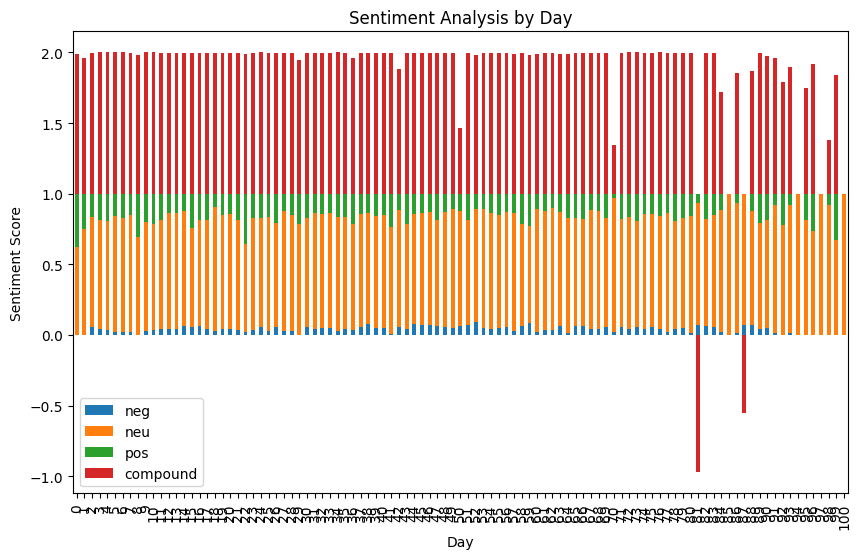

In [28]:
sentiment_res.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Sentiment Analysis by Day')
plt.xlabel('Day')
plt.ylabel('Sentiment Score')
plt.show()